### Instructions


The research question is can we use algorithms and compute to identify clothing items? Specifically, can we determine which algorithm and compute methodology provides us the most efficient approach for classifying simple fashion images?

Using the base samples available from Zalando Research:

* https://github.com/zalandoresearch/fashion-mnist 
* Review the data – clean as appropriate
* Provide an initial data analysis

Implement at least two approaches for classifying the digits – examples below: 

* Naïve bayes
* Neural Networks
* Keras
* AzureML
* IBMDSX
* Boostedtrees
* Linear classification 
* Your choice

Answer
* What is the accuracy of each method?
* What are the trade-offs of each approach?
* What is the compute performance of each approach?

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import keras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("Fashion_MNIST/", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting Fashion_MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting Fashion_MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting Fashion_MNIST/t10k-images-idx3-ubyte.gz
Extracting Fashion_MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
print("Number of training examples: %s" % mnist.train.num_examples)
print("Number of testing examples: %s" % mnist.test.num_examples) 

Number of training examples: 55000
Number of testing examples: 10000


In [4]:
print("Train images shape: {}".format(mnist.train.images.shape))
print("Test images shape: {}".format(mnist.test.images.shape))
print("Train labels shape: {}".format(mnist.train.labels.shape))
print("Test labels shape: {}".format(mnist.test.labels.shape))

Train images shape: (55000, 784)
Test images shape: (10000, 784)
Train labels shape: (55000, 10)
Test labels shape: (10000, 10)


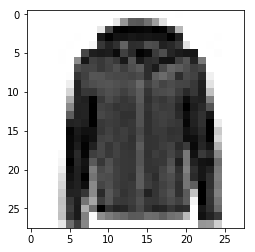

In [5]:
image1 = mnist.train.images[0]
image1 = np.reshape(image1, [28,28])
plt.imshow(image1, cmap= "Greys")

In [6]:
sample_images = []
indices = []
i = 0
while len(sample_images) < 10:
    label = np.argmax(mnist.train.labels[i])
    if label not in sample_images:
        sample_images.append(label)
        indices.append(i) 
    i += 1
label_pairs = [(label, i) for label, i in zip(sample_images, indices)]
label_pairs = sorted(label_pairs, key=lambda d:d[0] )

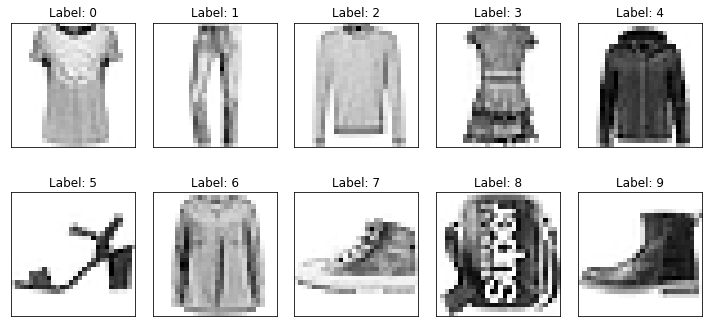

In [7]:
# VISUALIZE EACH OF THE DIGITS
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i, (label, index) in enumerate(label_pairs):
    img = mnist.train.images[index,].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title("Label: %d" % label)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Random Forest

In [8]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Train test split
X_train, X_test, y_train, y_test = train_test_split(mnist.train.images,
        mnist.train.labels, test_size = 0.2, random_state = 1000)

model = RandomForestClassifier(n_estimators= 100, n_jobs=-1, max_depth=100, criterion="entropy")
model.fit(mnist.train.images, mnist.train.labels)

CPU times: user 4min 7s, sys: 4.68 s, total: 4min 12s
Wall time: 22.6 s


In [9]:
%%time

from sklearn.metrics import accuracy_score

predictions = model.predict(mnist.test.images)
print("Accuracy of random forest model: {:4f}".format(accuracy_score(y_true= mnist.test.labels, y_pred=predictions)))

wrong_preds = [(i, np.argmax(tests[0]), np.argmax(tests[1])) 
               for i, tests in enumerate(zip(predictions, mnist.test.labels)) 
               if np.argmax(tests[0]) != np.argmax(tests[1])]

Accuracy of random forest model: 0.813500
CPU times: user 1.67 s, sys: 127 ms, total: 1.79 s
Wall time: 559 ms


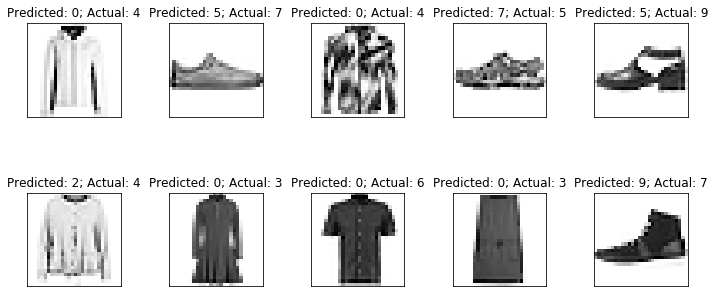

In [10]:
from sklearn.metrics import confusion_matrix

# visualize wrong predictions
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i, (ix, pred, actual) in enumerate(wrong_preds[:10]):
    img = mnist.test.images[ix,].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title("Predicted: %d; Actual: %d" % (pred, actual))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [11]:
predictions_argmax = [np.argmax(r) for r in predictions]
labels_argmax = [np.argmax(r) for r in mnist.test.labels]

with open('random_forest.csv', 'w') as f:
            f.write(np.array2string(confusion_matrix(y_pred=predictions_argmax, 
                                                     y_true=labels_argmax), separator=', '))

# Neural Network

## Single Layer Model

In [28]:
%%time

x = tf.placeholder(tf.float32, [None, 784])
W1 = tf.Variable(tf.zeros([784, 10]))
b1 = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W1) + b1)

y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
train_accuracy_list = []
epoch_list = []
test_accuracy_list = []

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for _ in range(20000):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    if _ % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys})
        train_accuracy_list.append(train_accuracy)
        epoch_list.append(_)
        validation_accuracy = accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels})
        test_accuracy_list.append(validation_accuracy)
        print("step {:d} training accuracy {:.2f}".format(_, train_accuracy))
    sess.run(train_step, feed_dict= {x:batch_xs, y_:batch_ys})

/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0 training accuracy 0.16
step 100 training accuracy 0.68
step 200 training accuracy 0.66
step 300 training accuracy 0.58
step 400 training accuracy 0.72
step 500 training accuracy 0.62
step 600 training accuracy 0.78
step 700 training accuracy 0.62
step 800 training accuracy 0.76
step 900 training accuracy 0.82
step 1000 training accuracy 0.78
step 1100 training accuracy 0.82
step 1200 training accuracy 0.72
step 1300 training accuracy 0.62
step 1400 training accuracy 0.76
step 1500 training accuracy 0.80
step 1600 training accuracy 0.66
step 1700 training accuracy 0.70
step 1800 training accuracy 0.84
step 1900 training accuracy 0.82
step 2000 training accuracy 0.76
step 2100 training accuracy 0.72
step 2200 training accuracy 0.86
step 2300 training accuracy 0.82
step 2400 training accuracy 0.82
step 2500 training accuracy 0.72
step 2600 training accuracy 0.78
step 2700 training accuracy 0.94
step 2800 training accuracy 0.86
step 2900 training accuracy 0.72
step 3000 training acc

Text(0.5,1,'Single Layer NN Learning Curve')

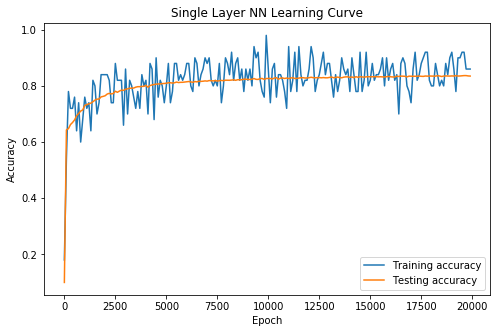

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
a = plt.plot(epoch_list, train_accuracy_list, epoch_list, test_accuracy_list)
plt.legend(["Training accuracy", "Testing accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Single Layer NN Learning Curve")

In [45]:
%%time
single_layer_accuracy = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
print("Single layer NN accuracy {:3f}".format(single_layer_accuracy))

Single layer NN accuracy 0.834400
CPU times: user 46 ms, sys: 5.21 ms, total: 51.2 ms
Wall time: 8.32 ms


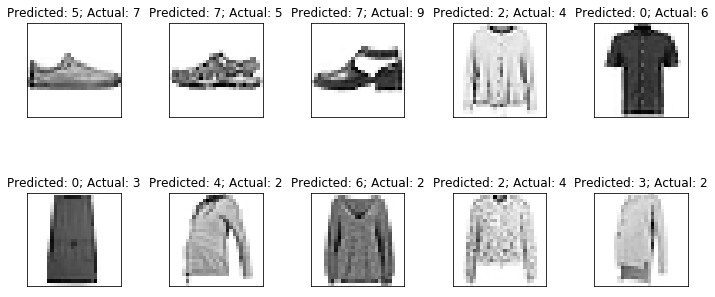

In [14]:
preds = sess.run(y, feed_dict={x:mnist.test.images})
wrong_preds_info = [(i, np.argmax(pred), np.argmax(actual)) for i, (pred, actual) in
    enumerate(zip(preds, mnist.test.labels.tolist())) if np.argmax(pred) != np.argmax(actual)]

# visualize wrong predictions
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i, (ix, pred, actual) in enumerate(wrong_preds_info[:10]):
    img = mnist.test.images[ix,].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title("Predicted: %d; Actual: %d" % (pred, actual))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [15]:
preds_label = [np.argmax(d) for d in preds]
actual_label = [np.argmax(d) for d in mnist.test.labels]

with open('single_nn_confmat.csv', 'w') as f:
            f.write(np.array2string(confusion_matrix(y_pred=preds_label, 
                                                     y_true=actual_label), separator=', '))

In [22]:
sess.close()

## Multilayer NN

In [3]:
#Function to return a hidden layer
def weight_variable(shape):
    #Randomly initializing the layer
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    #return the hidden layer
    return tf.Variable(initial)

#Function to return a bias variable
def bias_variable(shape):
    #initializing a random node
    initial = tf.constant(0.1, shape=shape)
    #returning the random node as a variable
    return tf.Variable(initial)

In [24]:
#Layer 1
x = tf.placeholder(tf.float32, [None, 784])
W1 = weight_variable([784, 1024])
b1 = bias_variable([1024])
layer1 = tf.nn.relu(tf.matmul(x, W1) + b1)

#Layer 2
W2 = weight_variable([1024, 512])
b2 = bias_variable([512])
layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)

#Layer 3
W3 = weight_variable([512, 128])
b3 = bias_variable([128])
layer3 = tf.nn.relu(tf.matmul(layer2, W3) + b3)

#Layer 4
W4 = weight_variable([128, 10])
b4 = bias_variable([10])
y = tf.nn.softmax(tf.matmul(layer3, W4) + b4)

In [25]:
%%time

y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
train_accuracy_list = []
epoch_list = []
test_accuracy_list = []

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for _ in range(20000):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    if _ % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys})
        print("step {:d} training accuracy {:.2f}".format(_, train_accuracy))
        train_accuracy_list.append(train_accuracy)
        epoch_list.append(_)
        validation_accuracy = accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels})
        test_accuracy_list.append(validation_accuracy)
    sess.run(train_step, feed_dict= {x:batch_xs, y_:batch_ys})

/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0 training accuracy 0.16
step 100 training accuracy 0.82
step 200 training accuracy 0.82
step 300 training accuracy 0.80
step 400 training accuracy 0.86
step 500 training accuracy 0.78
step 600 training accuracy 0.90
step 700 training accuracy 0.82
step 800 training accuracy 0.84
step 900 training accuracy 0.82
step 1000 training accuracy 0.86
step 1100 training accuracy 0.92
step 1200 training accuracy 0.80
step 1300 training accuracy 0.90
step 1400 training accuracy 0.88
step 1500 training accuracy 0.86
step 1600 training accuracy 0.92
step 1700 training accuracy 0.88
step 1800 training accuracy 0.82
step 1900 training accuracy 0.86
step 2000 training accuracy 0.90
step 2100 training accuracy 0.90
step 2200 training accuracy 0.86
step 2300 training accuracy 0.90
step 2400 training accuracy 0.92
step 2500 training accuracy 0.92
step 2600 training accuracy 0.84
step 2700 training accuracy 0.82
step 2800 training accuracy 0.86
step 2900 training accuracy 0.94
step 3000 training acc

Text(0.5,1,'Deep NN Learning Curve')

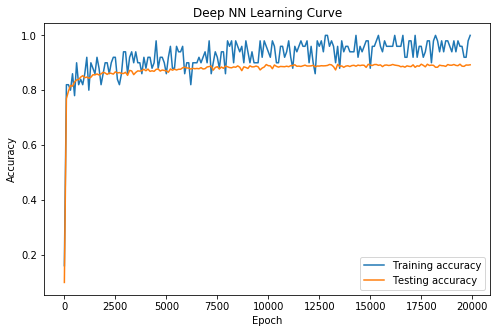

In [26]:
plt.rcParams["figure.figsize"] = (8,5)
a = plt.plot(epoch_list, train_accuracy_list, epoch_list, test_accuracy_list)
plt.legend(["Training accuracy", "Testing accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Deep NN Learning Curve")

In [58]:
%%time

multi_layer_accuracy = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
print("Multi layer NN accuracy {:3f}".format(multi_layer_accuracy))

Multi layer NN accuracy 0.891900
CPU times: user 1.22 s, sys: 18.7 ms, total: 1.24 s
Wall time: 128 ms


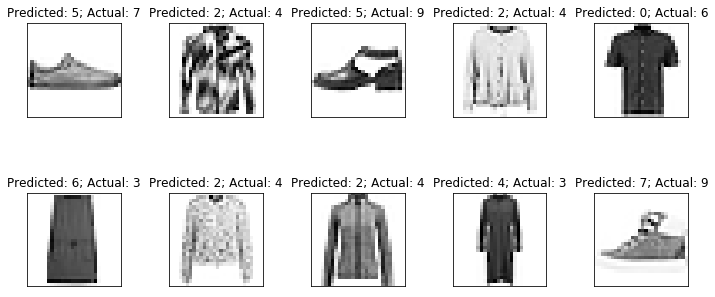

In [59]:
preds = sess.run(y, feed_dict={x:mnist.test.images})
actuals = mnist.test.labels

wrong_preds_info = [(i, np.argmax(pred), np.argmax(actual)) for i, (pred, actual) in
    enumerate(zip(preds.tolist(), actuals.tolist())) if np.argmax(pred) != np.argmax(actual)]

# visualize wrong predictions
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i, (ix, pred, actual) in enumerate(wrong_preds_info[:10]):
    img = mnist.test.images[ix,].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title("Predicted: %d; Actual: %d" % (pred, actual))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [60]:
preds_label = [np.argmax(d) for d in preds]
actual_label = [np.argmax(d) for d in mnist.test.labels]

with open('deep_nn_confmat.csv', 'w') as f:
            f.write(np.array2string(confusion_matrix(y_pred=preds_label, 
                                                     y_true=actual_label), separator=', '))

In [12]:
sess.close()

## Convolutional Neural Network

In [4]:
def convolutional_layer(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding = "SAME")

def pooling_layer(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = "SAME")

In [5]:
#variables needed x, keep_prob (dropout rate), y_
#Conv (relu) -> pool -> conv (relu) -> pool -> fc1 -> dropout -> fc2 -> dropout -> fc3 -> prediction
#Outwidth = (W - kw + 2P / S) + 1
x = tf.placeholder(tf.float32, [None, 784])


x_image = tf.reshape(x, [-1, 28, 28, 1])
#5x5x32 kernel size
W1 = weight_variable([5, 5, 1, 32])
b1 = bias_variable([32])
#Output size is 24x24x32
Conv1 = tf.nn.relu(convolutional_layer(x_image, W1) + b1)
#output size is 14x14x32
pool1 = pooling_layer(Conv1)


W2 = weight_variable([5,5,32,64])
b2 = bias_variable([64])
#output size is 8x8x64
Conv2 = tf.nn.relu(convolutional_layer(pool1, W2) + b2)
#output size is 4x4x64
pool2 = pooling_layer(Conv2)

#Fully connected layer 1
W3 = weight_variable([7*7*64, 1024])
b3 = bias_variable([1024])

pool2_flatten = tf.reshape(pool2, [-1, 7*7*64])
out3 = tf.nn.relu(tf.matmul(pool2_flatten, W3) + b3)
#Dropout after fully connected layer
keep_prob = tf.placeholder(tf.float32)
out3_dropped = tf.nn.dropout(out3, keep_prob)

#Fully  Connected layer 2
W4 = weight_variable([1024, 512])
b4 = bias_variable([512])
out4 = tf.nn.relu(tf.matmul(out3_dropped, W4) + b4)
out4_dropped = tf.nn.dropout(out4, keep_prob)

#Fully connected 3
W5 = weight_variable([512, 10])
b5 = bias_variable([10])
y = tf.nn.softmax(tf.matmul(out4_dropped, W5) + b5)

In [6]:
%%time

y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
train_accuracy_list = []
epoch_list = []
test_accuracy_list = []

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    if _ % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_:batch_ys, keep_prob:1.0})
        print("step {:d} training accuracy {:.2f}".format(_, train_accuracy))
        train_accuracy_list.append(train_accuracy)
        epoch_list.append(_)
        validation_accuracy = accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0})
        test_accuracy_list.append(validation_accuracy)        
    sess.run(train_step, feed_dict= {x:batch_xs, y_:batch_ys, keep_prob:0.5})

step 0 training accuracy 0.04
step 100 training accuracy 0.62
step 200 training accuracy 0.78
step 300 training accuracy 0.76
step 400 training accuracy 0.72
step 500 training accuracy 0.78
step 600 training accuracy 0.80
step 700 training accuracy 0.76
step 800 training accuracy 0.94
step 900 training accuracy 0.80
CPU times: user 9min 39s, sys: 2min 9s, total: 11min 48s
Wall time: 1min 24s


In [10]:
y.eval(feed_dict={x:mnist.train.next_batch(10)[0], keep_prob:1.0})
sess.close()

Text(0.5,1,'CNN Learning Curve')

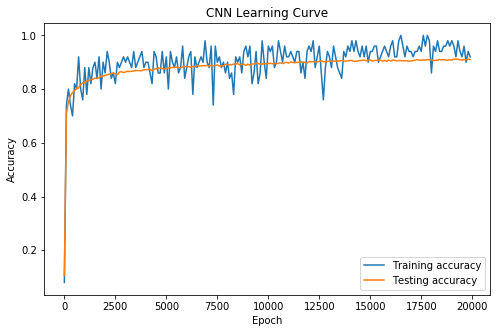

In [18]:
plt.rcParams["figure.figsize"] = (8,5)
a = plt.plot(epoch_list, train_accuracy_list, epoch_list, test_accuracy_list)
plt.legend(["Training accuracy", "Testing accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Learning Curve")

In [17]:
%%time

cnn_accuracy = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0})
print("CNN accuracy {:3f}".format(cnn_accuracy))

CNN accuracy 0.911400
CPU times: user 20 s, sys: 5.87 s, total: 25.9 s
Wall time: 2.94 s


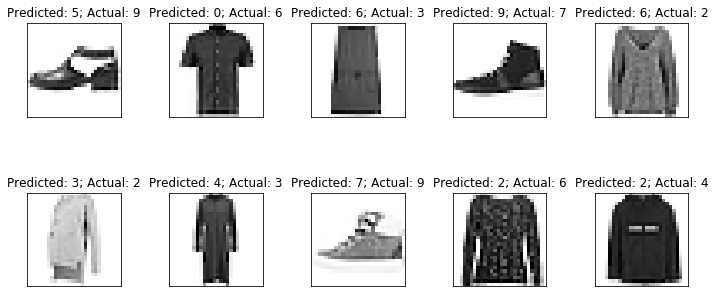

In [28]:

preds = sess.run(y, feed_dict={x:mnist.test.images, keep_prob:1.0})
actuals = mnist.test.labels

wrong_preds_info = [(i, np.argmax(pred), np.argmax(actual)) for i, (pred, actual) in
    enumerate(zip(preds.tolist(), actuals.tolist())) if np.argmax(pred) != np.argmax(actual)]

# visualize wrong predictions
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i, (ix, pred, actual) in enumerate(wrong_preds_info[:10]):
    img = mnist.test.images[ix,].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title("Predicted: %d; Actual: %d" % (pred, actual))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [30]:
preds_label = [np.argmax(d) for d in preds]
actual_label = [np.argmax(d) for d in mnist.test.labels]

with open('cnn_confmat.csv', 'w') as f:
            f.write(np.array2string(confusion_matrix(y_pred=preds_label, 
                                                     y_true=actual_label), separator=', '))

In [19]:
sess.close()

# VG16

In [30]:
#Getting the next batch of X and y
def next_batch(batchsize, documents, size = (256, 256), 
               classes = ["No Lung Opacity / Not Normal", "Lung Opacity", "Normal"]):
    """
    This function is meant to return the image array and the encoded labels for the 
    training of the neural network. 
    
    batchsize - int - how many instances you would want retreived
    
    documents - list - the list of documents you want the batch to come from
    
    size - tuple or list - the size of the output array want
    
    classes - Only change when not using the same three classes, keeps the labels the same
    """
    #randomly shuffles the documents
    idx = np.arange(0, len(documents))
    np.random.shuffle(idx)
    #Getting that number if indices
    idx = idx[:batchsize]
    #Creates a list for that batch
    batch = [documents[i] for i in idx]
    #A numpy matrix of the images
    X = np.zeros([batchsize, size[0], size[1], 3])
    #numpy array for the classes
    y = np.zeros([batchsize, 3])
    #Goes through the batch
    for i, d in enumerate(batch):
        #reads the file
        f = pyd.read_file(d["path"])
        #Inserts the reshaped image in the data frame
        X[i] = resize(image=np.stack([f.pixel_array] * 3, axis=2), output_shape=size)
        #One hot encodes the class
        y[i, classes.index(d["class"])] = 1
    return X, y

In [13]:
## from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Reshape, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Reshape(target_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(28,28,1), padding = "SAME"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding = "SAME"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
history = model.fit(batch_size=50,epochs=1000, 
                    x=mnist.train.images, y = mnist.train.labels, 
                    validation_data=(mnist.test.images, mnist.test.labels) )

Train on 55000 samples, validate on 10000 samples
Epoch 1/1000
55000/55000 [==============================] - 84s 2ms/step - loss: 0.2750 - acc: 0.8981 - val_loss: 0.2635 - val_acc: 0.9033
Epoch 2/1000
10900/55000 [====>.........................] - ETA: 1:05 - loss: 0.2296 - acc: 0.9136